In [ ]:
'''
    Here the goal is generte new molecules using GNNs. I will be trying different Graph architechtures as well as different approches 
    (auto regresssion, xavier bressson, GAN) ultimately the idea is to improve the GNN directory more (creating more layers etc) as well as learn more
    about GNNs so that after multiple application I can come up with a new model/layer myself. 

    Will use the ZINC and OM9 dataset hopefully benchmark them to produce better results than already existing methods.
        
'''

In [1]:
%cd ..

D:\ai\GNN


C:\Users\kkire\anaconda3\envs\dl\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
%pwd

'D:\\ai\\GNN'

In [32]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import ReLU, SiLU, Sigmoid, Sequential, LayerNorm, BatchNorm1d, Parameter

import torch_geometric
import torch_geometric.transforms as T 
from torch_geometric.nn import MessagePassing, Linear, global_mean_pool
from torch_geometric.nn.inits import zeros, glorot, reset
from torch_geometric.data import  Data, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import ZINC, QM9
from torch_geometric.utils import remove_self_loops

import rdkit.Chem as Chem
from rdkit.Geometry.rdGeometry import Point3D
from rdkit.Chem import QED, Crippen, rdMolDescriptors, rdmolops
from rdkit.Chem.Draw import IPythonConsole

from models.layers import GATConv, gConv, ChebConv, GIN

# import huggingface
import numpy as np
import os
import time
import tqdm


print("PyTorch version {}".format(torch.__version__))
print("PyG version {}".format(torch_geometric.__version__))

PyTorch version 2.3.1
PyG version 2.5.3


In [4]:
class SetTarget(object):
    """
    This transform mofifies the labels vector per data sample to only keep 
    the label for a specific target (there are 19 targets in QM9).

    Note: for this practical, we have hardcoded the target to be target #0,
    i.e. the electric dipole moment of a drug-like molecule.
    (https://en.wikipedia.org/wiki/Electric_dipole_moment)
    """
    def __call__(self, data):
        target = 0 # we hardcoded choice of target  
        data.y = data.y[:, target]
        return data
        
class CompleteGraph(object):
    """
    This transform adds all pairwise edges into the edge index per data sample, 
    then removes self loops, i.e. it builds a fully connected or complete graph
    """
    def __call__(self, data):
        device = data.edge_index.device

        row = torch.arange(data.num_nodes, dtype=torch.long, device=device)
        col = torch.arange(data.num_nodes, dtype=torch.long, device=device)

        row = row.view(-1, 1).repeat(1, data.num_nodes).view(-1)
        col = col.repeat(data.num_nodes)
        edge_index = torch.stack([row, col], dim=0)

        edge_attr = None
        if data.edge_attr is not None:
            idx = data.edge_index[0] * data.num_nodes + data.edge_index[1]
            size = list(data.edge_attr.size())
            size[0] = data.num_nodes * data.num_nodes
            edge_attr = data.edge_attr.new_zeros(size)
            edge_attr[idx] = data.edge_attr

        edge_index, edge_attr = remove_self_loops(edge_index, edge_attr)
        data.edge_attr = edge_attr
        data.edge_index = edge_index

        return data

In [5]:
allowable_atoms = [
    "H",
    "C",
    "N",
    "O",
    "F",
    "C",
    "Cl",
    "Br",
    "I",
    "H", 
    "Unknown",
]

atoms2Z = {0:1, 1:6, 2:7, 3:8, 4:9}

def to_atom(t):
    try:
        return allowable_atoms[int(t.argmax())]
    except:
        return "C"


def to_bond_index(t):
    t_s = t.squeeze()
    return [1, 2, 3, 4][
        int(
            torch.dot(
                t_s,
                torch.tensor(
                    range(t_s.size()[0]), dtype=torch.float, device=t.device
                ),
            ).item()
        )
    ]

def to_rdkit(data, device=None):
    has_pos = False
    node_list = []
    for i in range(data.x.size()[0]):
        node_list.append(to_atom(data.x[i][:5]))

    # create empty editable mol object
    mol = Chem.RWMol()
    # add atoms to mol and keep track of index
    node_to_idx = {}
    invalid_idx = set([])
    for i in range(len(node_list)):
        if node_list[i] == "Stop" or node_list[i] == "H":
            invalid_idx.add(i)
            continue
        a = Chem.Atom(node_list[i])
        molIdx = mol.AddAtom(a)
        node_to_idx[i] = molIdx

    added_bonds = set([])
    for i in range(0, data.edge_index.size()[1]):
        ix = data.edge_index[0][i].item()
        iy = data.edge_index[1][i].item()
        bond = to_bond_index(data.edge_attr[i])  # <font color='red'>TODO</font> fix this
        # bond = 1
        # add bonds between adjacent atoms

        if data.edge_attr[i].sum() == 0:
          continue

        if (
            (str((ix, iy)) in added_bonds)
            or (str((iy, ix)) in added_bonds)
            or (iy in invalid_idx or ix in invalid_idx)
        ):
            continue
        # add relevant bond type (there are many more of these)

        if bond == 0:
            continue
        elif bond == 1:
            bond_type = Chem.rdchem.BondType.SINGLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
        elif bond == 2:
            bond_type = Chem.rdchem.BondType.DOUBLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
        elif bond == 3:
            bond_type = Chem.rdchem.BondType.TRIPLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
        elif bond == 4:
            bond_type = Chem.rdchem.BondType.SINGLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)

        added_bonds.add(str((ix, iy)))

    if has_pos:
        conf = Chem.Conformer(mol.GetNumAtoms())
        for i in range(data.pos.size(0)):
            if i in invalid_idx:
                continue
            p = Point3D(
                data.pos[i][0].item(),
                data.pos[i][1].item(),
                data.pos[i][2].item(),
            )
            conf.SetAtomPosition(node_to_idx[i], p)
        conf.SetId(0)
        mol.AddConformer(conf)

    # Convert RWMol to Mol object
    mol = mol.GetMol()
    mol_frags = rdmolops.GetMolFrags(mol, asMols=True, sanitizeFrags=False)
    largest_mol = max(mol_frags, default=mol, key=lambda m: m.GetNumAtoms())
    return largest_mol


def MolTo3DView(mol, size=(300, 300), style="stick", surface=False, opacity=0.5):
    """Draw molecule in 3D
    
    Args:
    ----
        mol: rdMol, molecule to show
        size: tuple(int, int), canvas size
        style: str, type of drawing molecule
               style can be 'line', 'stick', 'sphere', 'carton'
        surface, bool, display SAS
        opacity, float, opacity of surface, range 0.0-1.0
    Return:
    ----
        viewer: py3Dmol.view, a class for constructing embedded 3Dmol.js views in ipython notebooks.
    """
    assert style in ('line', 'stick', 'sphere', 'carton')

    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol, maxIters=200)
    mblock = Chem.MolToMolBlock(mol)
    viewer = py3Dmol.view(width=size[0], height=size[1])
    viewer.addModel(mblock, 'mol')
    viewer.setStyle({style:{}})
    if surface:
        viewer.addSurface(py3Dmol.SAS, {'opacity': opacity})
    viewer.zoomTo()
    return viewer

def smi2conf(smiles):
    '''Convert SMILES to rdkit.Mol with 3D coordinates'''
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        AllChem.MMFFOptimizeMolecule(mol, maxIters=200)
        return mol
    else:
        return None

In [6]:
path = './experiments/qm9'
dataset = QM9(path)

In [7]:
transform = T.Compose([CompleteGraph(), SetTarget()])
dataset.transform = transform

In [8]:
target = 0
# Normalize targets per data sample to mean = 0 and std = 1.
mean = dataset.data.y.mean(dim=0, keepdim=True)
std = dataset.data.y.std(dim=0, keepdim=True)
dataset.data.y = (dataset.data.y - mean) / std
mean, std = mean[:, target].item(), std[:, target].item()
print(f"Total number of samples: {len(dataset)}.")

# Split datasets (in case of using the full dataset)
# test_dataset = dataset[:10000]
# val_dataset = dataset[10000:20000]
# train_dataset = dataset[20000:]

# Split datasets (our 3K subset)
train_dataset = dataset[:1000]
val_dataset = dataset[1000:2000]
test_dataset = dataset[2000:3000]
print(f"Created dataset splits with {len(train_dataset)} training, {len(val_dataset)} validation, {len(test_dataset)} test samples.")

# Create dataloaders with batch size = 32
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Total number of samples: 130831.
Created dataset splits with 1000 training, 1000 validation, 1000 test samples.


C:\Users\kkire\anaconda3\envs\dl\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


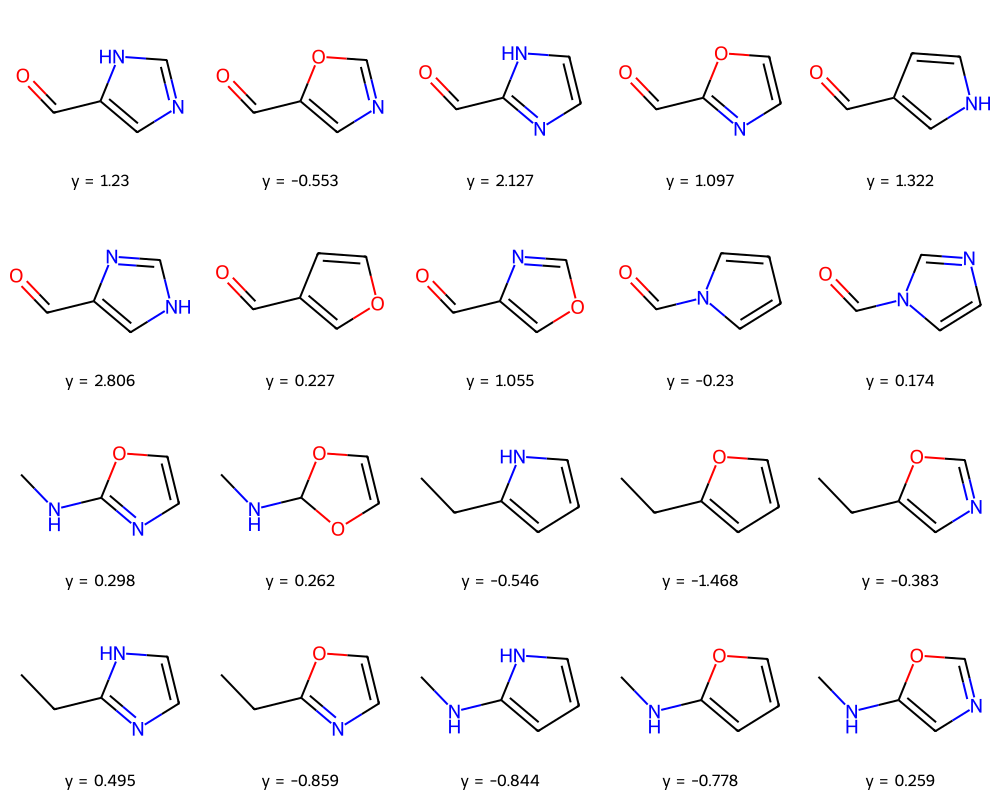

In [9]:
num_viz = 20
mols = [to_rdkit(val_dataset[i]) for i in range(num_viz)]
values = [str(round(float(val_dataset[i].y), 3)) for i in range(num_viz)]

Chem.Draw.MolsToGridImage(mols, legends=[f"y = {value}" for value in values], molsPerRow=5)

In [ ]:
'''
    Methond 1 : https://arxiv.org/pdf/1906.03412 : Xavier bresson's method of 2 step decoder and beam search
'''

In [10]:
%load_ext autoreload
%autoreload 2

In [11]:
def get_params(model : nn.Module):

    total_param = 0
    for param in model.parameters():
        total_param += np.prod(list(param.data.size()))

    return total_param

In [39]:
r = 0
for d in tqdm.tqdm(dataset):
     r = max(r, d.x.size()[0])
print(r)

100%|█| 130831/130831 [01:11<00:00, 1822.99i

29


In [12]:
class GraphEncoder(MessagePassing):

    def __init__(self, filters : list, emb_dim, edge_dim, node_in_dim, edge_in_dim, latent_dim, mu=0, sigma=1.0, activation='relu', norm='batch', add_self_loops=False):

        super().__init__()
        
        self.emb_dim = emb_dim
        self.edge_dim = edge_dim
        self.node_in_dim = node_in_dim
        self.edge_in_dim = edge_in_dim
        self.latent_dim = latent_dim
        
        self.mu = mu
        self.sigma = sigma

        self.activation = self.activation = {"silu": SiLU(), "relu": ReLU(), 'sigmoid':Sigmoid()}[activation]
        self.norm = {"layer": LayerNorm, "batch": BatchNorm1d}[norm]
        
        
        self.gate_activation = Sigmoid()

        self.node_lin_in = Linear(node_in_dim, emb_dim, bias=False, weight_initializer='glorot')
        self.edge_lin_in = Linear(edge_in_dim, edge_dim, bias=False, weight_initializer='glorot')

        self.filters = [emb_dim] + filters
                
        self.convs = nn.ModuleList()
        
        for i in range(len(self.filters)-1):
            self.convs.append(GATConv(self.filters[i], self.filters[i+1], edge_dim=edge_dim, add_self_loops=add_self_loops, update_edges=True))

        self.phi_1 = Linear(self.filters[-1], self.latent_dim, bias=False, weight_initializer='glorot')
        self.phi_2 = Linear(self.filters[-1], self.latent_dim, bias=False, weight_initializer='glorot')
        self.phi_3 = Linear(self.edge_dim, self.latent_dim, bias=False, weight_initializer='glorot')
        self.phi_4 = Linear(self.edge_dim, self.latent_dim, bias=False, weight_initializer='glorot')
        
        
    def forward(self, x, edge_index, edge_attr, batch):

        x = self.node_lin_in(x)
        edge_attr = self.edge_lin_in(edge_attr)
        
        for i in range(len(self.convs)): 
            x, edge_attr = self.convs[i](x, edge_index, edge_attr)
            
            x = self.norm(self.filters[i+1])(x)
            x = self.activation(x)
            
            edge_attr = self.norm(self.edge_dim)(edge_attr)
            edge_attr = self.activation(edge_attr)

        out = self.edge_updater(edge_index, x=x, edge_attr=edge_attr)
        

        out = torch_geometric.nn.global_add_pool(out, batch)
        
        return out
    
    def edge_update(self, x_i, x_j, edge_attr):
        
        out = self.phi_1(x_i) + self.phi_2(x_j) + self.phi_3(edge_attr)
        out = self.gate_activation(out)
        out = out * self.phi_4(edge_attr) 

        return out
    

In [27]:
class GraphDecoder(MessagePassing):
    def __init__(self, filters : list, latent_dim, M, R, emb_dim, edge_dim, add_self_loops=False, batch_size=32):
        
        super().__init__()
        
        self.latent_dim = latent_dim
        self.M = M
        self.R = R
        self.emb_dim = emb_dim
        self.edge_dim = edge_dim
        self.filters = filters
        self.batch_size = batch_size

        self.mlp = Sequential(
            Linear(self.latent_dim, 512, bias=True, weight_initializer='glorot'),
            ReLU(),
            Linear(512, 512, bias=True, weight_initializer='glorot'),
            ReLU(),
            Linear(512, 256, bias=True, weight_initializer='glorot'),
            ReLU(),
            Linear(256, self.M * self.R, bias=True, weight_initializer='glorot')
        )

        self.convs = nn.ModuleList()
        for i in range(len(self.filters)-1):
            self.convs.append(GATConv(filters[i], filters[i+1], edge_dim=self.edge_dim, add_self_loops=add_self_loops, update_edges=True))
        
        self.edge_mlp = Sequential(
                Linear(self.edge_dim, 128),
                ReLU(),
                Linear(128, 64),
                ReLU(),
                Linear(64, 16),
                ReLU(),
                Linear(16, 4)
        )

        self.lin_in_node = Linear(5, self.filters[0], bias=False, weight_initializer='glorot')
        self.lin_in_edge = Linear(self.latent_dim, self.edge_dim)
        
    
    def forward(self, z):

        out = self.mlp(z)
        out = out.view(-1, self.M, self.R)
        out = torch.nn.functional.softmax(out, dim=2)
        z_boa = torch.max(out, dim=2).indices
        
        x, edge_index, edge_attr, batch_map = self.construct_graph(z_boa, z, self.lin_in_edge)

        
        x = self.lin_in_node(x)

        for i in range(len(self.convs)):
            x, edge_attr = self.convs[i](x, edge_index, edge_attr)

        edge_attr = self.edge_mlp(edge_attr)

        return edge_attr, batch_map[edge_index[0]]

    
    def construct_graph(self, z_boa, z, project):
        batch_size, atom_types = z_boa.shape
        device = z_boa.device
    
        # Calculate the total number of atoms
        total_atoms = z_boa.sum().int().item()
    
        # Create x: one-hot encoding of atom types
        x = torch.zeros(total_atoms, atom_types, device=device)
        start_idx = 0
        batch_map = torch.zeros(total_atoms, dtype=torch.long, device=device)
        
        for i in range(batch_size):
            num_atoms_batch = z_boa[i].sum().int().item()
            end_idx = start_idx + num_atoms_batch
            
            # One-hot encoding for atoms in this batch
            x[start_idx:end_idx] = torch.nn.functional.one_hot(
                torch.arange(atom_types, device=device).repeat_interleave(z_boa[i].int()),
                num_classes=atom_types
            )
            
            # Map these atoms to their batch
            batch_map[start_idx:end_idx] = i
            
            start_idx = end_idx
    
        # Create edge_index and prepare edge_attr
        edge_index = []
        edge_attr = []
        start_idx = 0
        
        
        for i in range(batch_size):
            num_atoms_batch = z_boa[i].sum().int().item()
            end_idx = start_idx + num_atoms_batch
            
            # Fully connect atoms within this batch
            batch_edge_index = torch.combinations(torch.arange(start_idx, end_idx, device=device), r=2).t()
            edge_index.append(batch_edge_index)
            
            # Project z for this batch to edge_attr_dim
            batch_z_proj = project(z[i].float().unsqueeze(0))  # [1, edge_attr_dim]
            
            # Repeat the projected z_boa for each edge in this batch
            num_edges_batch = batch_edge_index.shape[1]
            batch_edge_attr = batch_z_proj.repeat(num_edges_batch, 1)  # [num_edges_batch, edge_attr_dim]
            
            edge_attr.append(batch_edge_attr)
            
            start_idx = end_idx
    
        edge_index = torch.cat(edge_index, dim=1)
        edge_attr = torch.cat(edge_attr, dim=0)
    
        return x, edge_index, edge_attr, batch_map
    

In [28]:
ge = GraphEncoder([32, 64, 128, 256], 16, 16, 11, 4, 512)
gd = GraphDecoder([256, 128, 64, 32], 512, 5, 29, 32, 32)
print("number of paramerters for GraphEncoder:",  get_params(ge))

with torch.no_grad():
    for d in val_loader:
        x = ge(d.x, d.edge_index, d.edge_attr, d.batch[d.edge_index[0]])
        print(x.shape)
        out, edge_batch = gd(x)
        print(out.shape, edge_batch.shape)
        break

number of paramerters for GraphEncoder: 340592
torch.Size([32, 512])
torch.Size([94140, 4]) torch.Size([94140])


In [31]:
print(torch.unique(edge_batch, return_counts=True))

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]), tensor([2926, 1953, 2926, 1953, 2775, 2926, 2628, 1953, 2775, 2926, 4095, 2556,
        1176, 5253, 2415, 4278, 2415, 4278, 2278, 4095, 4095, 2278, 1176, 4095,
        2556, 4095, 2556, 4186, 2628, 1431, 4186, 2278]))
